In [1]:
# This code study kinematic profile of MW, M31 merger remenant,
# by calculates velocity dispersion and rotation curve. 

In [1]:
# import all modules needed 
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile
from Lab7 import RotateFrame, density_contour

from scipy.stats import binned_statistic
import matplotlib.pyplot as plt

In [44]:

# combine those into single data set 
# numpy.concatenate() 
# https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html 
class Remnant: 
    
    
    def __init__(self, Galaxy1 , Galaxy2, Snap): # create center of mass object for MW and M31, snapshot #560 corresponding 8.0 Gyrs from now
    
    
        self.Snap = Snap 

        # add a string of the filenumber to the value “000”
        ilbl = '000' + str(Snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        filename1 ="%s_"%(Galaxy1) + ilbl + '.txt'
        filename2 ="%s_"%(Galaxy2) + ilbl + '.txt'
        
        time1, total1, data1 = Read(filename1)  
        time2, total2, data2 = Read(filename2)  

        data = np.concatenate((data1, data2))
        index = np.where(data['type'] != 1 )

        self.remnants = data[index] 

    
    def mkfile(self):
        # add a string of the filenumber to the value “000”
        ilbl = '000' + str(self.Snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        self.filename ="Remnant_" + ilbl + '.txt'

    #     change to calculate time 
        time = 7999.99999
        n_particles = len(self.remnants)

        with open(self.filename, 'w') as f:

            f.write(f"Time   {time:.5f}\n")
            f.write(f"Total       {n_particles}\n")
            f.write("mass in 1e10,  x, y, z, in kpc and vx, vy, vz in km/s\n")

            # Header line
            header = "{:>11s} {:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}".format(
                'type', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz')
            f.write(header + "\n")

            # Write each row with different formatting for 'm'
            for row in self.remnants:
                formatted_row = "{:11.0f} {:11.9f}{:11.4f}{:11.4f}{:11.4f}{:11.4f}{:11.4f}{:11.4f}".format(
                    row[0],  # type
                    row[1],  # m (mass) with 9 decimal places
                    row[2], row[3], row[4],  # x, y, z
                    row[5], row[6], row[7]   # vx, vy, vz
                )
                f.write(formatted_row + "\n")
                     
                     
    def V_circ(self):
        """Create rotation curve, circular velocity of all mass enclosed in given radius. 
        """
        Rm = MassProfile("Remnant", self.Snap)
        rr = np.arange(0.01, 45, 0.1)

        # Circular Velocity Profile
        Vcirc = Rm.CircularVelocityTotal(rr)

        # Make a phase diagram of the R vs V
        # MW Disk Velocity Field edge on.

        fig = plt.figure(figsize=(12,10))
        ax = plt.subplot(111)


        # Overplot Circular Velocity from the MassProfile Code
        plt.plot(rr,Vcirc, color='red')
        plt.plot(-rr, -Vcirc, color='red')

        # Add axis labels
        plt.xlabel('x (kpc)', fontsize=22)
        plt.ylabel('Vy (km/s) ', fontsize=22)

        #adjust tick label font size
        label_size = 22
        matplotlib.rcParams['xtick.labelsize'] = label_size 
        matplotlib.rcParams['ytick.labelsize'] = label_size

        # Save file
        plt.savefig('RotationCurve.png')
        
        
    def RotateAxis(self): 
            # recalculate center of COM with Disk particles
        COMD = CenterOfMass(self.filename, 2)

        # Compute COM of remenent using disk particles
        COMP = COMD.COM_P(0.1)
        COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])
        # print(f"Center of Mass : {COMP}")

        # Determine positions of disk particles relative to COM 
        xD = COMD.x - COMP[0].value 
        yD = COMD.y - COMP[1].value 
        zD = COMD.z - COMP[2].value 

        # total magnitude
        rtot = np.sqrt(xD**2 + yD**2 + zD**2)

        # Determine velocities of disk particles relatiev to COM motion
        vxD = COMD.vx - COMV[0].value 
        vyD = COMD.vy - COMV[1].value 
        vzD = COMD.vz - COMV[2].value 

        # total velocity 
        vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)

        #Array for r and v
        r = np.array([xD,yD,zD]).T # transposed 
        v = np.array([vxD,vyD,vzD]).T

        self.rn, self.vn = RotateFrame(r, v)
    
    def EdgeOnVIew(self): 
        # Rotated M31 Disk - EDGE ON

        # M31 Disk Density 
        fig, ax= plt.subplots(figsize=(15, 10))

        # plot the particle density for M31 , 2D histogram
        # plt.hist2d(rn[:,0], rn[:,2], bins=900, norm=LogNorm(vmin=1), cmap='magma') # face-on 
        plt.hist2d(self.rn[:,0], self.rn[:,1], bins=900, norm=LogNorm(vmin=1), cmap='magma') # edge-on 

        # density_contour(rn[:,0], rn[:,1], 80, 80, ax=ax, colors=['yellow', 'red','white', 'yellow'])
        
        cbar = plt.colorbar()
        cbar.set_label("Number of disk particle per bin", fontsize=15)


        # Add axis labels
        plt.xlabel('x (kpc)', fontsize=22)
        plt.ylabel('z (kpc)', fontsize=22)

        #set axis limits
        plt.ylim(-30,30)
        plt.xlim(-30,30)

        #adjust tick label font size
        label_size = 22
        matplotlib.rcParams['xtick.labelsize'] = label_size 
        matplotlib.rcParams['ytick.labelsize'] = label_size

    def V_Phi(self): 
        # make a plot of rotation curve, v vs r in cylindical coord (this may olny use to make sure it have rotation profile)
        x, y, z = self.rn[:,0], self.rn[:,1], self.rn[:,2]
        vx, vy, vz = self.vn[:,0], self.vn[:,1], self.vn[:,2]

        # Cylindrical radius
        R = np.sqrt(x**2 + y**2)

        # Cylindrical velocity components
        v_phi = (x * vy - y * vx) / R
        v_R   = (x * vx + y * vy) / R
        v_z   = vz

        bins = np.linspace(0, R.max(), 100)
        vphi_mean, _, _ = binned_statistic(R, v_phi, statistic='mean', bins=bins)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        
        return bin_centers, vphi_mean
        
    def Vmax_over_sigma(self, R_target,v_max):
        """
        Compute v_max / sigma for all particles within R_target.
        σ is computed as the standard deviation of azimuthal velocities.

        Parameters:
        -----------
        R_target : float
            Max cylindrical radius (kpc) for particle selection.
        v_max : float
            v_max value to divide by sigma.

        Returns:
        --------
        v_max_over_sigma : float
            Ratio of v_max to velocity dispersion sigma.
        """
        x, y = self.rn[:, 0], self.rn[:, 1]
        vx, vy = self.vn[:, 0], self.vn[:, 1]

        # Cylindrical radius
        R = np.sqrt(x**2 + y**2)

        v_phi = (x * vy - y * vx) / R

        # Select particles within R_target
        mask = R <= R_target
        v_phi_cut = v_phi[mask]

        if len(v_phi_cut) < 5:
            return np.nan

        sigma = np.std(v_phi_cut)
        if sigma == 0:
            return np.nan

        return v_max / sigma

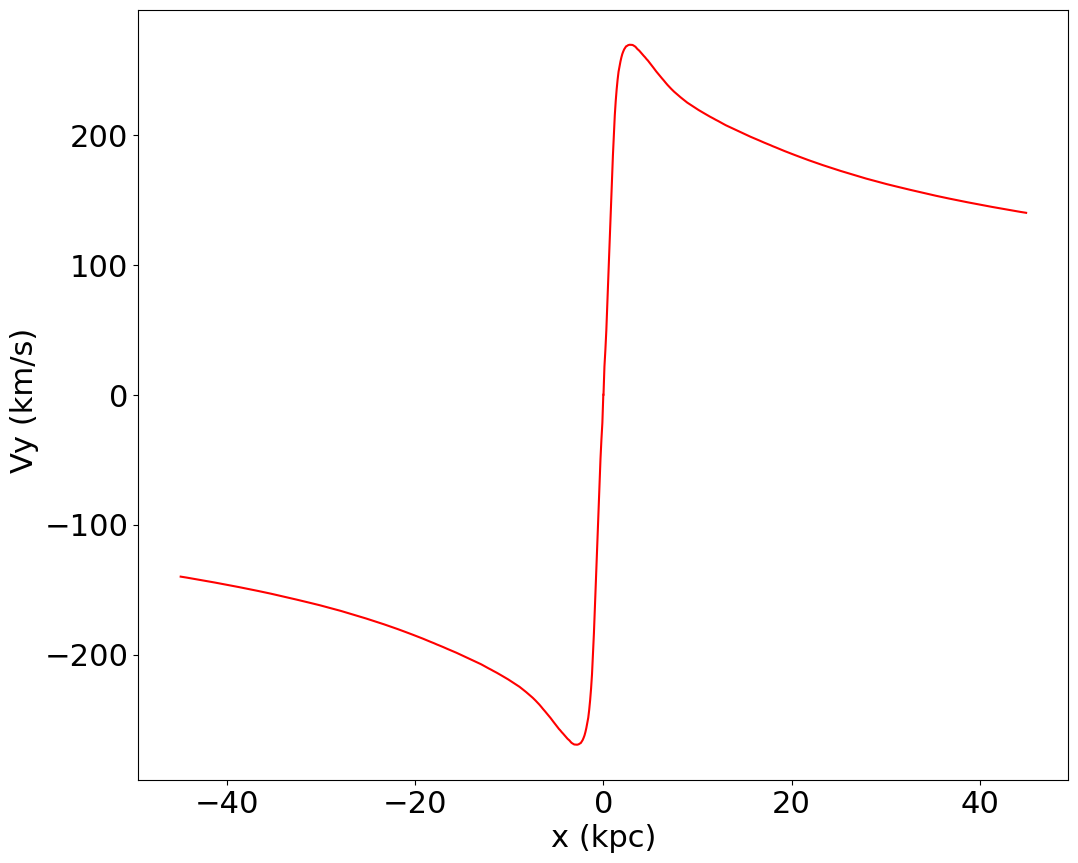

In [45]:
MW_M31 = Remnant("MW","M31", 560)
MW_M31.mkfile()
MW_M31.V_circ()

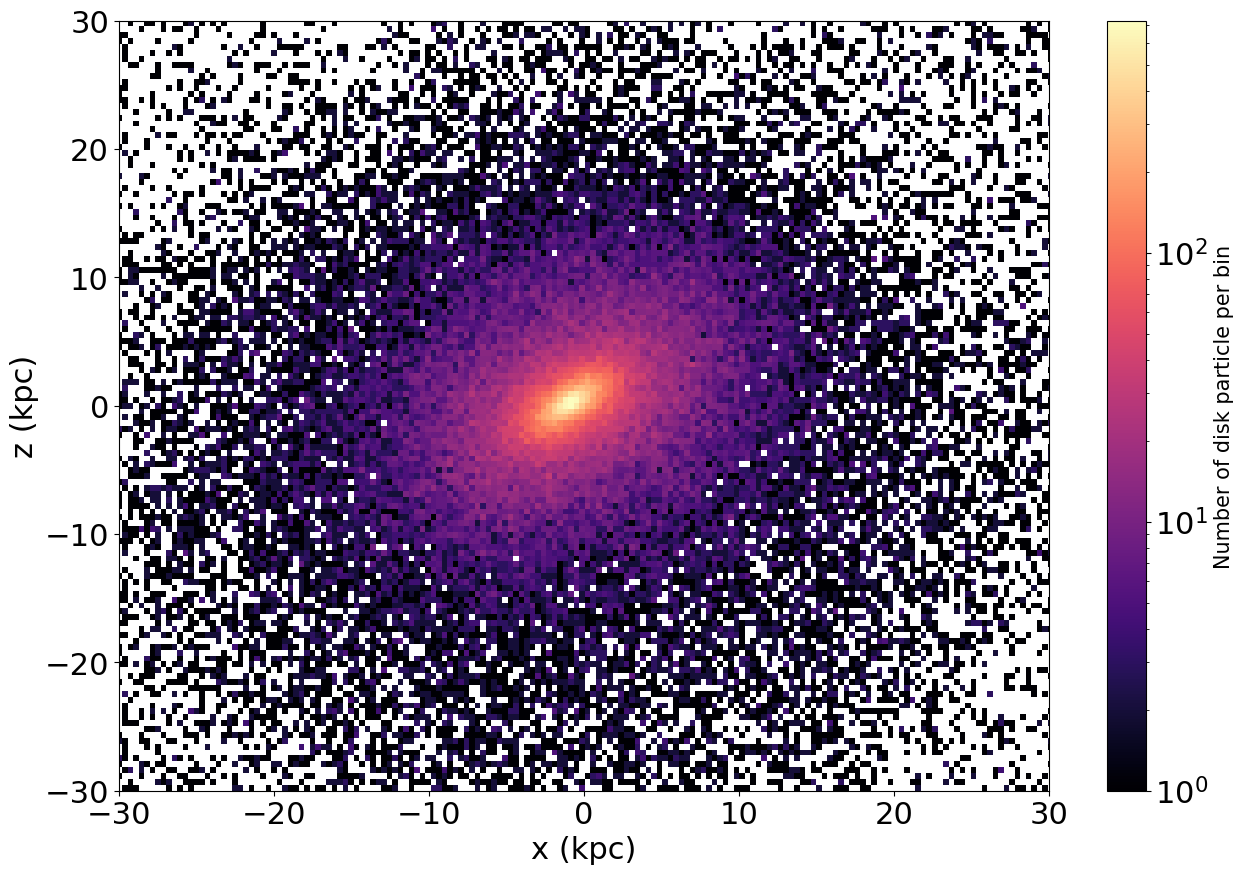

In [46]:
MW_M31.RotateAxis()
MW_M31.EdgeOnVIew()

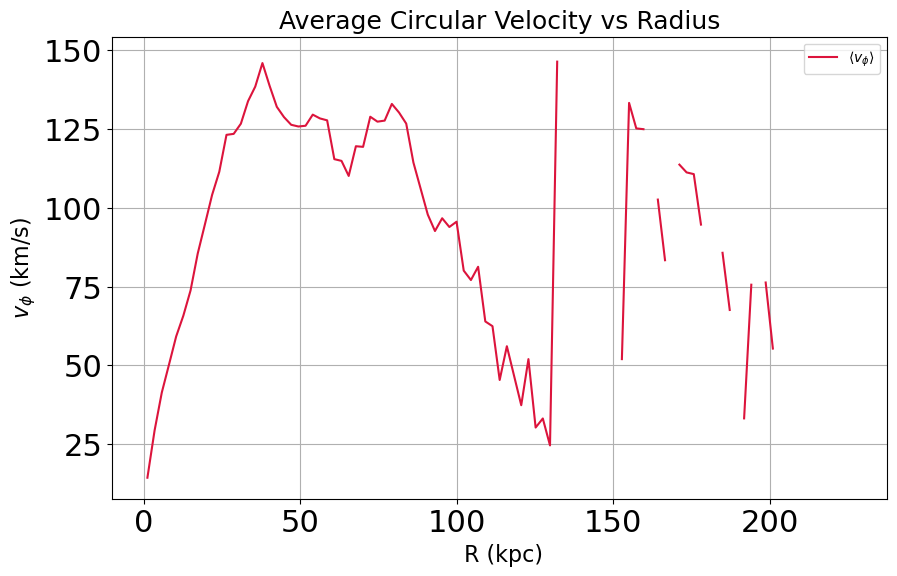

In [47]:
r, vphi = MW_M31.V_Phi()


plt.figure(figsize=(10,6))
plt.plot(r, vphi, label=r"$\langle v_\phi \rangle$", color='crimson')
plt.xlabel(" R (kpc)", fontsize=16)
plt.ylabel(r"$v_\phi$ (km/s)", fontsize=16)
plt.title("Average Circular Velocity vs Radius", fontsize=18)
plt.grid(True)
plt.legend()

In [31]:
# calculate v/ sigma by using particles various radius .
# the actual average circular motions of the particles directly. translate v_x and v_y into v_phi (cylindical) and compute average 

